## 1. Graph Attention Networks

In [6]:
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Numpy for matrices
import numpy as np
np.random.seed(0)

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Dataset

In [82]:
from torch_geometric.datasets import Planetoid,KarateClub

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="cora")

data = dataset[0]


### Print information about the dataset

In [83]:
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: cora()
-------------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [84]:
from torch_geometric.utils import remove_isolated_nodes

isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 0


### Plot dataset

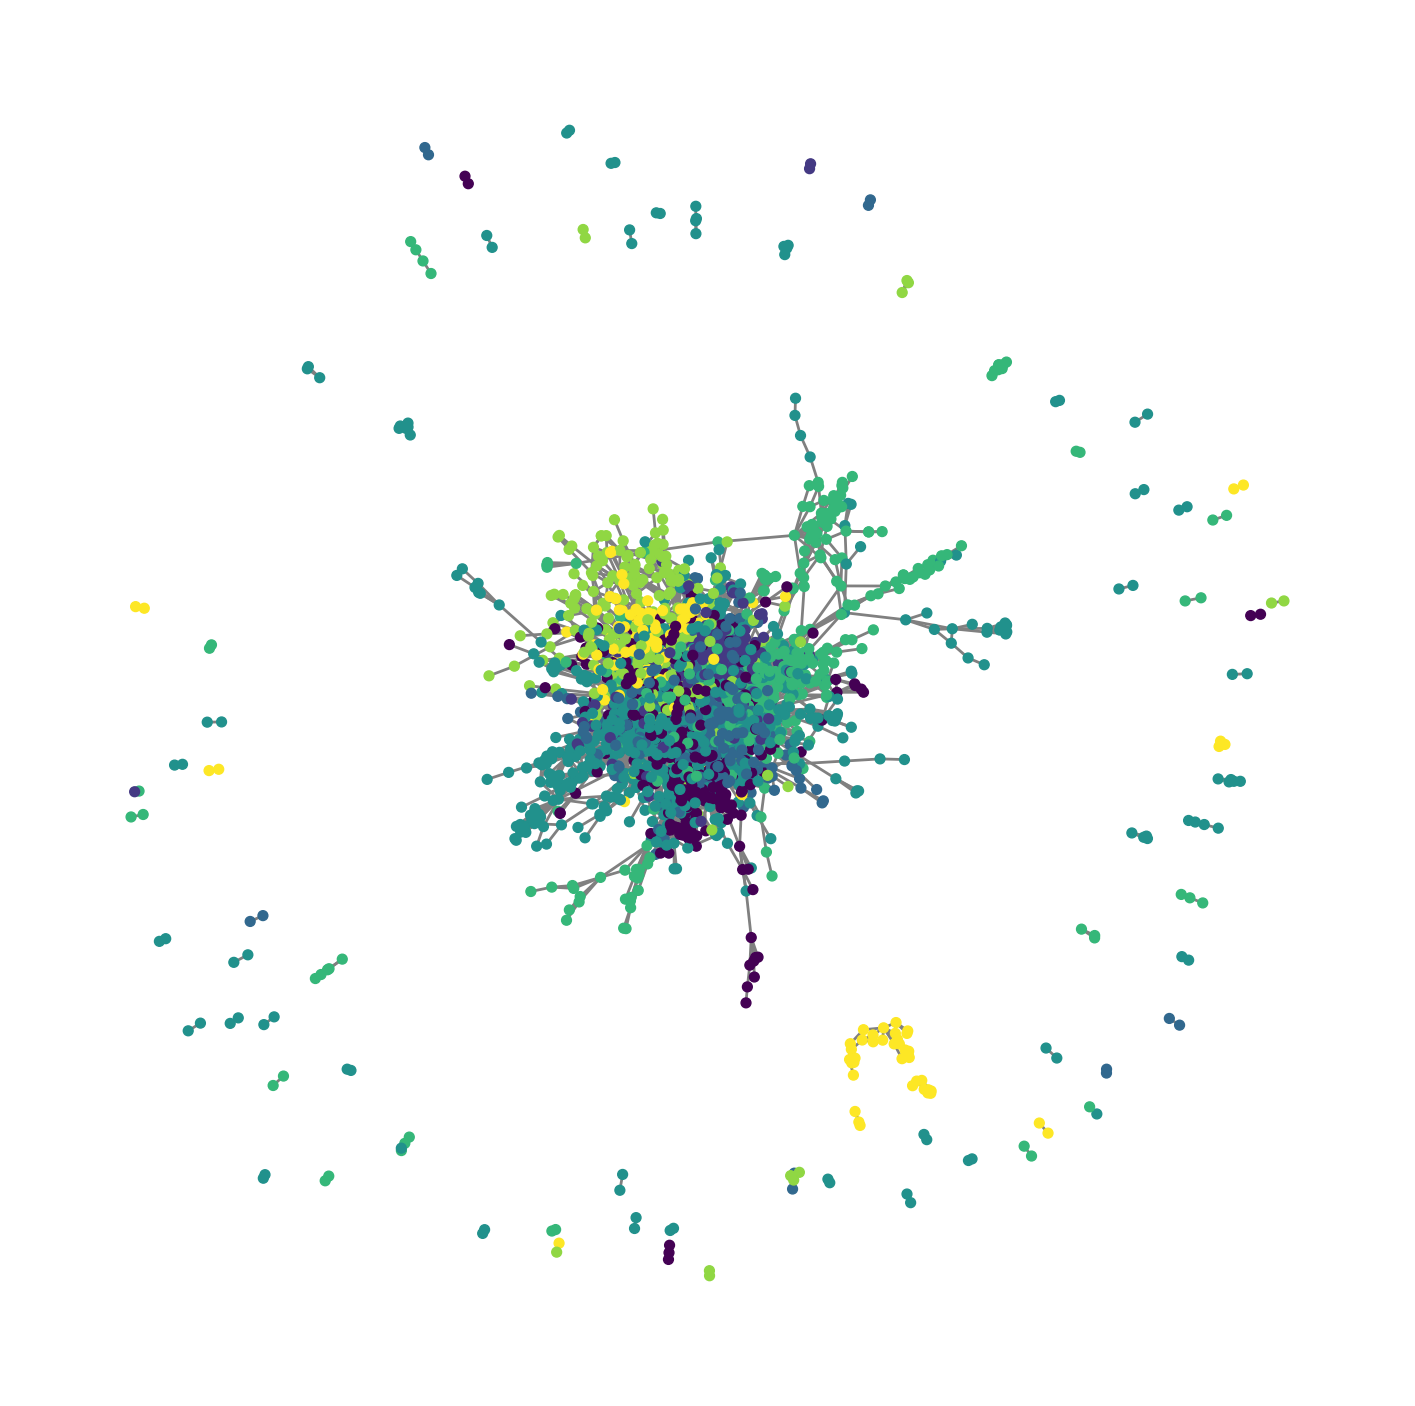

In [85]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

### Plot node degrees

<BarContainer object of 37 artists>

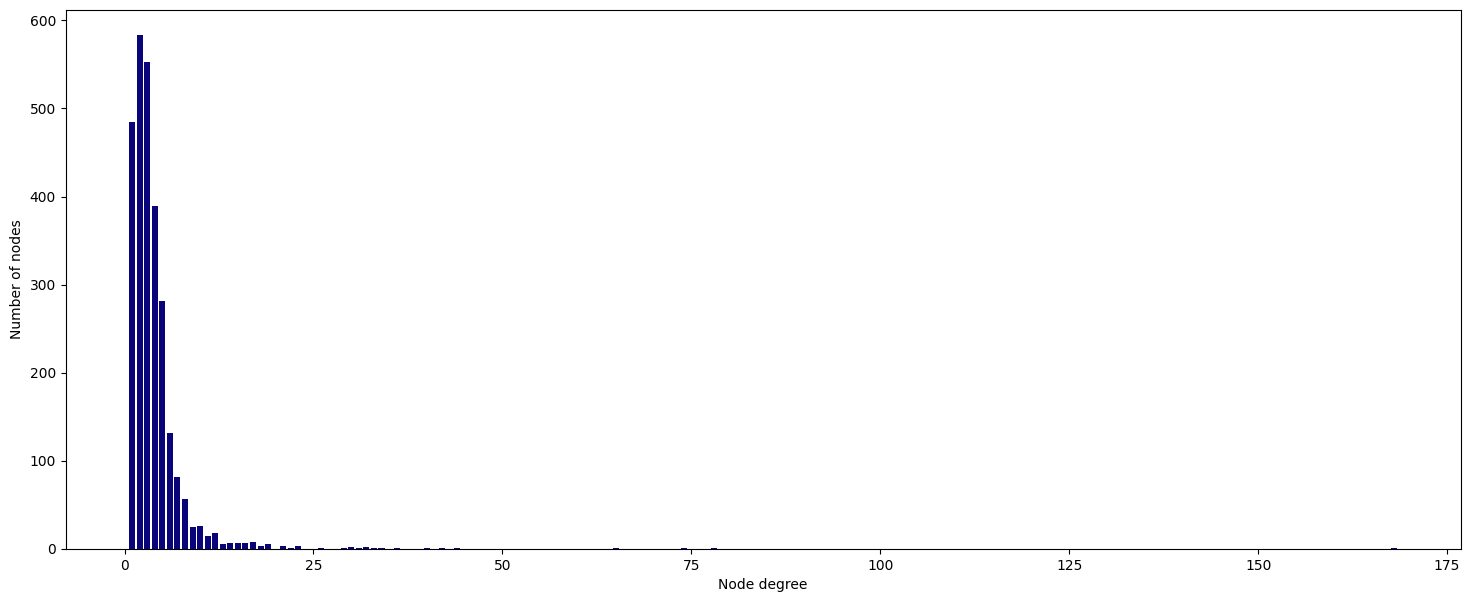

In [86]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

### Implement GAT vs. GCN

#### GCN model

In [87]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

#### GAT model

In [88]:
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

### Train function

In [89]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 5

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 1 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

In [90]:
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

### Train GCN

In [91]:
%%time

# Create GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train(gcn, data)

# Test
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.973 | Train Acc:   8.57% | Val Loss: 1.95 | Val Acc: 10.60%
Epoch   1 | Train Loss: 1.876 | Train Acc:  43.57% | Val Loss: 1.91 | Val Acc: 33.60%
Epoch   2 | Train Loss: 1.774 | Train Acc:  70.00% | Val Loss: 1.86 | Val Acc: 46.80%
Epoch   3 | Train Loss: 1.670 | Train Acc:  72.14% | Val Loss: 1.79 | Val Acc: 50.40%
Epoch   4 | Train Loss: 1.538 | Train Acc:  71.43% | Val Loss: 1.70 | Val Acc: 58.20%
Epoch   5 | Train Loss: 1.431 | Train Acc:  75.71% | Val Loss: 1.63 | Val Acc: 57.80%

GCN test accuracy: 70.20%

CPU times: total: 4.78 s
Wall time: 629 ms


### Train GAT

In [92]:
%%time

# Create GAT model
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)

GAT(
  (gat1): GATv2Conv(1433, 8, heads=8)
  (gat2): GATv2Conv(64, 7, heads=1)
)
CPU times: total: 15.6 ms
Wall time: 3.01 ms


In [93]:


# Train
train(gat, data)

# Test
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 1.947 | Train Acc:  15.00% | Val Loss: 1.97 | Val Acc: 13.80%
Epoch   1 | Train Loss: 1.725 | Train Acc:  73.57% | Val Loss: 1.83 | Val Acc: 43.40%
Epoch   2 | Train Loss: 1.519 | Train Acc:  95.00% | Val Loss: 1.71 | Val Acc: 65.80%
Epoch   3 | Train Loss: 1.330 | Train Acc:  94.29% | Val Loss: 1.61 | Val Acc: 72.60%
Epoch   4 | Train Loss: 1.142 | Train Acc:  96.43% | Val Loss: 1.50 | Val Acc: 74.40%
Epoch   5 | Train Loss: 0.980 | Train Acc:  97.14% | Val Loss: 1.39 | Val Acc: 75.40%

GAT test accuracy: 78.10%



### t-SNE plots

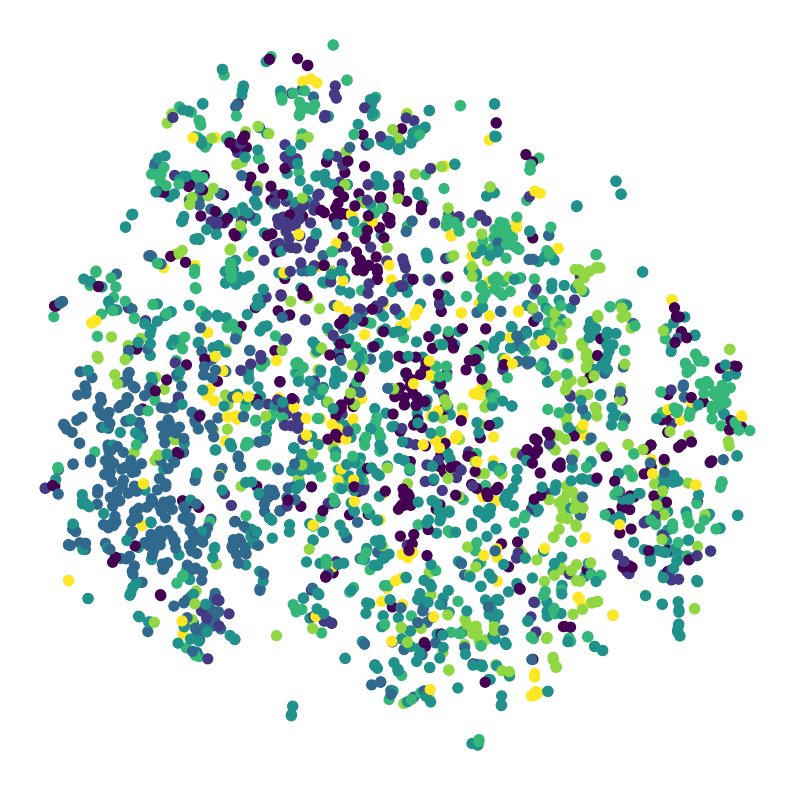

In [94]:
# Initialize new untrained model
untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

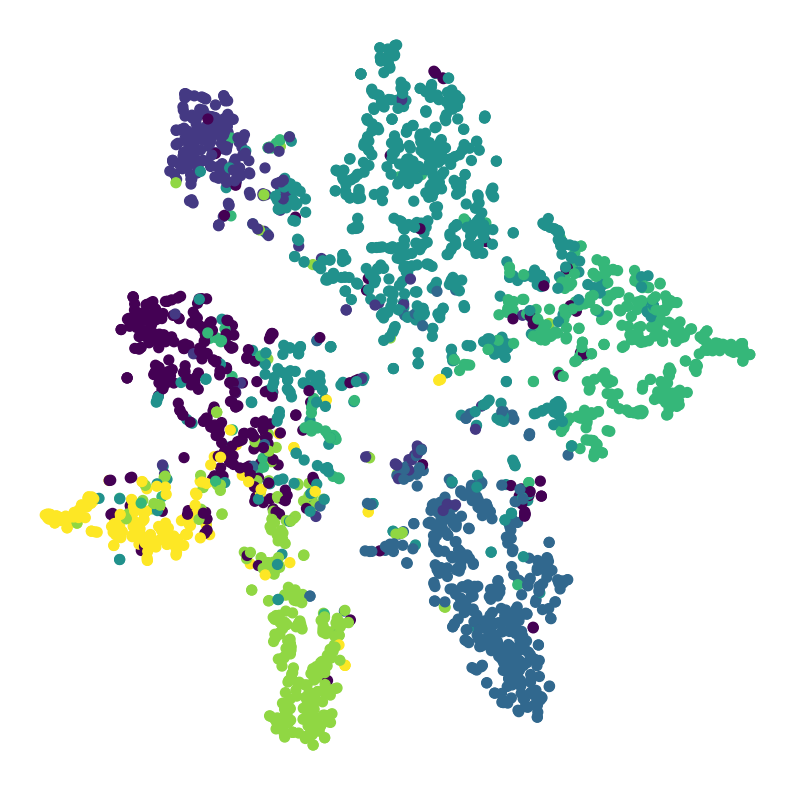

In [95]:
# Get embeddings
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

### Plot accuracy for each node degree

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


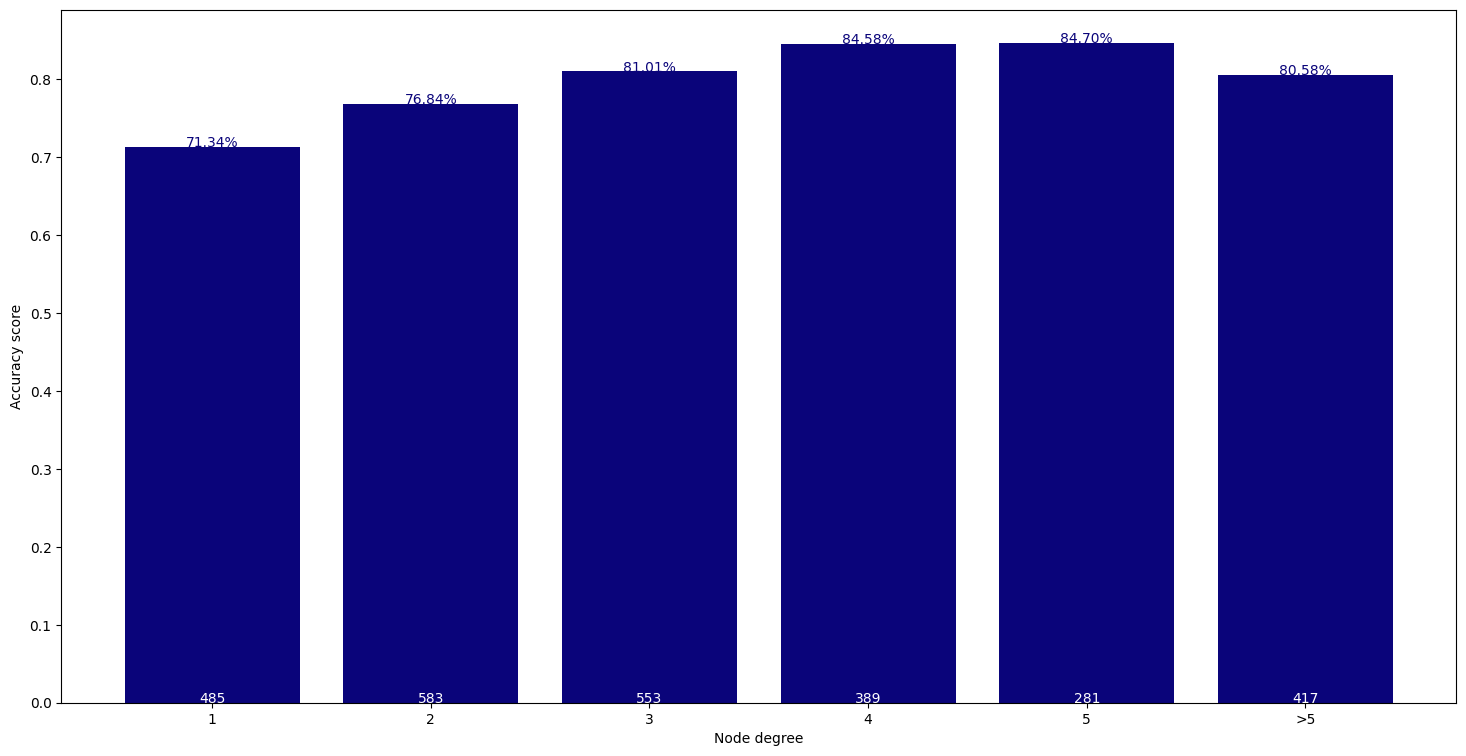

In [96]:
from torch_geometric.utils import degree

# Get model's classifications
_, out = gat(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()


# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
  mask = np.where(degrees == i)[0]
  accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
  sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','>5'],
        accuracies,
        color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%',
             ha='center', color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i],
             ha='center', color='white')

## 2. Graph Isomorphism Network

In [97]:
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GINConv

In [98]:
class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, num_features, num_classes, dim=16, drop=0.5):
        super(GIN, self).__init__()
        nn1 = Sequential(Linear(num_features, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, num_classes))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(num_classes)
        self.drop = torch.nn.Dropout(p=0.5)
        
        self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

    def forward(self, x, edge_index):
        x = F.selu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = self.drop(x)
        x = F.selu(self.conv2(x, edge_index))
        x = self.bn2(x)
        return x, F.softmax(x, dim=1)

In [99]:
%%time

# Create GIN model
gin = GIN(dataset.num_features, 8, dataset.num_classes)
print(gat)

GAT(
  (gat1): GATv2Conv(1433, 8, heads=8)
  (gat2): GATv2Conv(64, 7, heads=1)
)
CPU times: total: 0 ns
Wall time: 2 ms


In [100]:
# Train
train(gin, data)

# Test
acc = test(gin, data)
print(f'\nGIN test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 2.052 | Train Acc:  19.29% | Val Loss: 2.07 | Val Acc: 14.00%
Epoch   1 | Train Loss: 2.034 | Train Acc:  20.00% | Val Loss: 2.06 | Val Acc: 15.20%
Epoch   2 | Train Loss: 2.015 | Train Acc:  25.71% | Val Loss: 2.05 | Val Acc: 20.80%
Epoch   3 | Train Loss: 1.987 | Train Acc:  30.00% | Val Loss: 2.05 | Val Acc: 22.20%
Epoch   4 | Train Loss: 1.956 | Train Acc:  35.71% | Val Loss: 2.04 | Val Acc: 22.80%
Epoch   5 | Train Loss: 1.937 | Train Acc:  37.14% | Val Loss: 2.03 | Val Acc: 26.20%

GIN test accuracy: 26.70%

